In [7]:
import numpy as np
import pandas as pd
from PyEMD import EMD 
from scipy.signal import convolve
from scipy.signal import butter, lfilter, freqz
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib
from utils import process_raw_data, process_phantom
import json
# Default settings
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use("seaborn-darkgrid")

C:\Users\dicky1031\AppData\Local\Temp\ipykernel_35596\1177801975.py:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-darkgrid")


## Format Setting

In [3]:
# global
# time_resolution = 0.20487 # [sec/point]
baseline_start = 0 # [sec]
baseline_end = 60 # [sec]
HP_start = 60 # [sec]
HP_end = 75 # [sec]
recovery_start = 75 # [sec]
recovery_end = 675 # [sec] 

# setting
moving_window = 3 # [nm]
time_interval = 30 # [sec]

# SDS2
time_resolution = 0.1 # [sec/point]
using_SDS = 20 # [mm]
date = '20230812'
subject = 'HW'
phantom_measured_ID = ['2', '3', '4', '5']
SDS_idx = 4  # SDS=20 mm, phantom simulated idx

previous_date = '20230819'
previous_phantom_measured_ID = ['2','3','4','5']

exp = 'VM'
mother_folder_name = os.path.join(subject, "SDS2", date, exp)
background_filenpath = os.path.join("dataset", subject, "SDS2", date,'background.csv')
data_filepath = os.path.join("dataset", subject, "SDS2", date, f'{subject}_{exp}.csv')

## Initialize Processer Instance

In [22]:
process_raw_data.create_folder(mother_folder_name)

Processer = process_raw_data(baseline_start=baseline_start,
                             baseline_end=baseline_end,
                             HP_start=HP_start,
                             HP_end=HP_end,
                             recovery_start=recovery_start,
                             recovery_end=recovery_end,
                             time_resolution=time_resolution,
                             time_interval=time_interval,
                             mother_folder_name=mother_folder_name,
                             using_SDS=using_SDS)


## Get Background Data

target = []


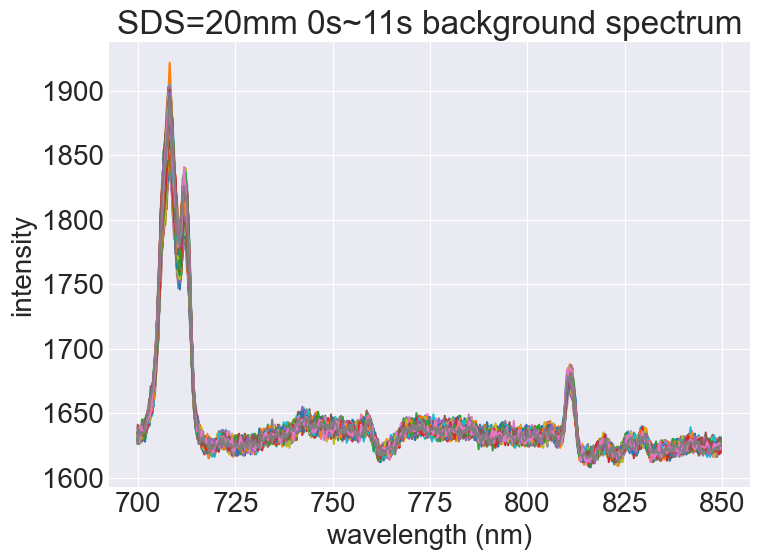

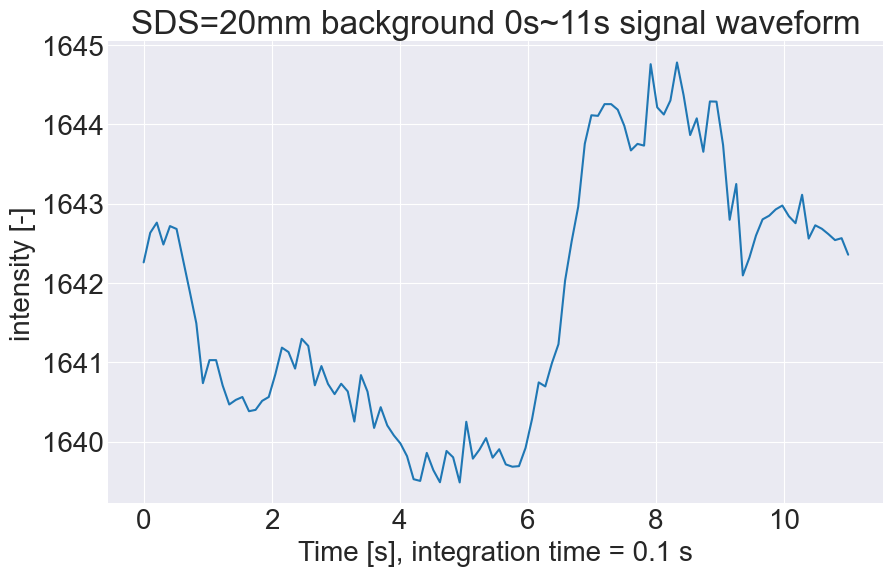

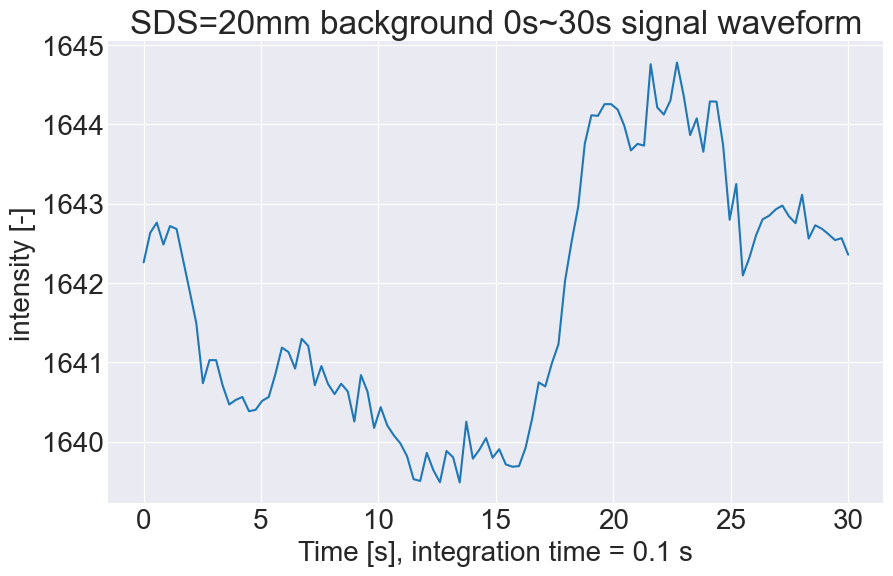

In [23]:
# load data
raw_bg, total_wl = process_raw_data.read_file(background_filenpath)

# select range 700nm~850nm
idx_700nm = np.argmin(np.abs(total_wl-700))
idx_850nm = np.argmin(np.abs(total_wl-850))

# get background data
raw_bg, total_wl = raw_bg[:, idx_700nm:idx_850nm], total_wl[idx_700nm:idx_850nm]
bg_no_spike = Processer.remove_spike(wl=total_wl, 
                                    data=raw_bg, 
                                    normalStdTimes=6, 
                                    ts=0)
bg_time_mean = bg_no_spike.mean(0)
bg_wl_mean = bg_no_spike.mean(1)

# plot background data
Processer.plot_all_time_spectrum(data=raw_bg,
                    wavelength=total_wl,
                    name='background',
                    start_time=0,
                    end_time=round(raw_bg.shape[0]*time_resolution),
                    is_show = True)
Processer.plot_signal(data=raw_bg,
            name='background',
            start_time=0,
            end_time=round(raw_bg.shape[0]*time_resolution),
            is_show = True)
for ts in range(0,round(raw_bg.shape[0]*time_resolution),time_interval):
    td = ts + time_interval
    if ts == 0:
            is_show = True
    else:
            is_show = False
    Processer.plot_signal(data=raw_bg,
            name='background',
            start_time=ts,
            end_time=td,
            is_show = is_show)

## Process Raw in-vivo Data

In [29]:
# load raw data
raw_data, total_wl = Processer.read_file(data_filepath)

# select range 700nm~850nm
idx_700nm = np.argmin(np.abs(total_wl-700))
idx_850nm = np.argmin(np.abs(total_wl-850))
raw_data, total_wl = raw_data[:, idx_700nm:idx_850nm], total_wl[idx_700nm:idx_850nm]

def remove_spike(wl, data, normalStdTimes, ts):
    # data : Nx --> time, Ny --> wavelength 
    data_no_spike = data.copy()
    mean = data_no_spike.mean(axis=0)
    std = data_no_spike.std(ddof=1, axis=0)
    targetSet = []  # save spike idx
    for idx, s in enumerate(data_no_spike):  # iterate spectrum in every time frame
        isSpike = np.any(abs(s-mean) > normalStdTimes*std)
        if isSpike:
            targetSet.append(idx) 
    print(f"target = {targetSet}")
    # if len(targetSet) != 0:
    #     for target in targetSet:
    #         # show target spec and replace that spec by using average of the two adjacents
    #         plt.plot(wl, data_no_spike[target])
    #         plt.xlabel("Wavelength [nm]")
    #         plt.ylabel("Intensity [counts]")    
    #         plt.title(f"spike idx: {target}")
    #         plt.savefig(os.path.join("pic", self.mother_folder_name, "spectrum", 'remove_spike_and_bg', f'{ts+target*self.time_resolution:.2f}s_spike.png'), dpi=300, format='png', bbox_inches='tight')
    #         plt.close()
    #         if ((target+1) < data_no_spike.shape[0]) & ((target-1) >= 0 ): 
    #             data_no_spike[target] = (data_no_spike[target-1] + data_no_spike[target+1]) / 2
    #         elif (target+1) == data_no_spike.shape[0]:
    #             data_no_spike[target] = data_no_spike[target-1]
    #         elif (target-1) <= 0:
    #             data_no_spike[target] = data_no_spike[target+1]
            
    return targetSet

## EMD
data_EMD = raw_data.copy()
# remove all-time signal based at first
imfs = EMD().emd(raw_data.mean(axis=1))
imfs[-1] -= imfs[-1].mean()
artifact = imfs[2:] 
# remove artifact
for art in artifact:
    data_EMD -= art.reshape(-1, 1)

# remove peaks
data_no_spike = raw_data.copy()
for ts in range(0, recovery_end, 10):
    td = ts + 10
    for wl in range(raw_data.shape[1]):
        remove_idx = remove_spike(wl=total_wl,
                                  data=data_EMD[round(ts/time_resolution):round(td/time_resolution), wl],
                                  normalStdTimes=3, 
                                  ts=ts)
        if len(remove_idx) != 0:
            data_no_spike[round(ts/time_resolution)+np.array(remove_idx),wl] = data_no_spike[round(ts/time_resolution):round(td/time_resolution),wl].mean()
        
# # remove spike
# data_no_spike = data_EMD.copy()
# for ts in range(0, recovery_end, 10):
#     td = ts + 10
#     data_no_spike[round(ts/time_resolution):round(td/time_resolution)] = Processer.remove_spike(total_wl, 
#                                                                                                 data_EMD[round(ts/time_resolution):round(td/time_resolution)], 
#                                                                                                 normalStdTimes=5, 
#                                                                                                 ts=ts)

# subtract background
data_sub_bg = data_no_spike - bg_time_mean

# moving average
for i in range(data_sub_bg.shape[0]):
    if i == 0:
        moving_avg_I_data, moving_avg_wl_data = process_raw_data.moving_avg(moving_window, total_wl, data_sub_bg[i,:])
        moving_avg_I_data = moving_avg_I_data.reshape(1,-1)
        data_moving_avg = moving_avg_I_data
    else:
        moving_avg_I_data, moving_avg_wl_data = process_raw_data.moving_avg(moving_window, total_wl, data_sub_bg[i,:])
        moving_avg_I_data = moving_avg_I_data.reshape(1,-1) 
        data_moving_avg = np.concatenate((data_moving_avg,moving_avg_I_data))

## Low Pass Filter-
# # Filter requirements.
# order = 6
# fs = 1/time_resolution # sample rate, Hz
# cutoff = 3  # desired cutoff frequency of the filter, Hz
# # Filter the data, and plot both the original and filtered signals.
# LPF_data = data_moving_avg.copy()
# for i in range(data_moving_avg.shape[1]):
#     LPF_data[:,i] = process_raw_data.butter_lowpass_filter(data_moving_avg[:,i], cutoff, fs, order)

## EMD
data_EMD = data_moving_avg.copy()
# remove all-time signal based at first
imfs = EMD().emd(data_moving_avg.mean(axis=1))
imfs[-1] -= imfs[-1].mean()
artifact = imfs[2:] 
# remove artifact
for art in artifact:
    data_EMD -= art.reshape(-1, 1)

# detect peak 
is_peak = np.zeros(data_EMD.shape[0])
for ts in range(0, recovery_end, time_interval):
    td = ts+time_interval
    data_signal = data_EMD[round(ts/time_resolution):round(td/time_resolution), :].mean(axis=1)
    max_idx, min_idx = process_raw_data.get_peak_final(data_signal)
    is_peak[min_idx + round(ts/time_resolution)] = -1
    is_peak[max_idx + round(ts/time_resolution)] = 1

# ## EMD used as processed data
# data_EMD = data_moving_avg.copy()
# imfs = EMD().emd(data_moving_avg.mean(axis=1))
# imfs[-1] -= imfs[-1].mean()
# artifact = imfs[2:] 
# # remove artifact
# for art in artifact:
#     data_EMD[round(0/time_resolution):round(baseline_end/time_resolution), :] -= art.reshape(-1, 1)[round(0/time_resolution):round(baseline_end/time_resolution), :]
#     data_EMD[round(recovery_start/time_resolution):round(recovery_end/time_resolution), :] -= art.reshape(-1, 1)[round(recovery_start/time_resolution):round(recovery_end/time_resolution), :]
##
# # baseline
# imfs = EMD().emd(data_moving_avg[round(0/time_resolution):round(baseline_end/time_resolution), :].mean(axis=1))
# imfs[-1] -= imfs[-1].mean()
# artifact = imfs[2:] 
# # remove artifact
# for art in artifact:
#     data_EMD[round(0/time_resolution):round(baseline_end/time_resolution), :] -= art.reshape(-1, 1)
# # recovery
# imfs = EMD().emd(data_moving_avg[round(recovery_start/time_resolution):round(recovery_end/time_resolution), :].mean(axis=1))
# imfs[-1] -= imfs[-1].mean()
# artifact = imfs[2:] 
# # remove artifact
# for art in artifact:
#     data_EMD[round(recovery_start/time_resolution):round(recovery_end/time_resolution), :] -= art.reshape(-1, 1)


# save result 
save_result = {}
time = [i*time_resolution for i in range(data_moving_avg.shape[0])]
save_result['time(s)'] = time
save_result['peak'] = is_peak # max:+1, min:-1
for idx, using_wl in enumerate(moving_avg_wl_data):
    save_result[f'{using_wl}nm'] = data_EMD[:,idx]
save_result = pd.DataFrame(save_result)
save_result.to_csv(os.path.join("dataset", mother_folder_name, f"in_vivo_result_{exp}.csv"), index=False)

target = []
target = []
target = []
target = []
target = []
target = []
target = []
target = []
target = []
target = []
target = [90]
target = []
target = []
target = [62]
target = []
target = [99]
target = [95, 96]
target = [99]
target = [94, 99]
target = [94, 95]
target = [95, 97, 98]
target = [94, 97, 98]
target = [96, 98]
target = [94, 96, 98, 99]
target = [94, 98, 99]
target = [95, 96, 99]
target = [95, 96]
target = []
target = []
target = []
target = [94]
target = []
target = [97, 99]
target = [95, 98]
target = [94]
target = [95]
target = [99]
target = []
target = []
target = []
target = [91]
target = []
target = [63]
target = [70, 79]
target = []
target = []
target = []
target = []
target = []
target = []
target = []
target = []
target = []
target = [38]
target = []
target = []
target = [15]
target = []
target = []
target = [41]
target = []
target = [31]
target = []
target = []
target = []
target = []
target = []
target = []
target = []
target = []
target = []
target = []
target

In [30]:
# save result 
save_result = {}
time = [i*time_resolution for i in range(data_moving_avg.shape[0])]
save_result['time(s)'] = time
save_result['peak'] = is_peak # max:+1, min:-1
for idx, using_wl in enumerate(moving_avg_wl_data):
    save_result[f'{using_wl}nm'] = data_moving_avg[:,idx]
save_result = pd.DataFrame(save_result)
save_result.to_csv(os.path.join("dataset", mother_folder_name, f"in_vivo_result_{exp}.csv"), index=False)

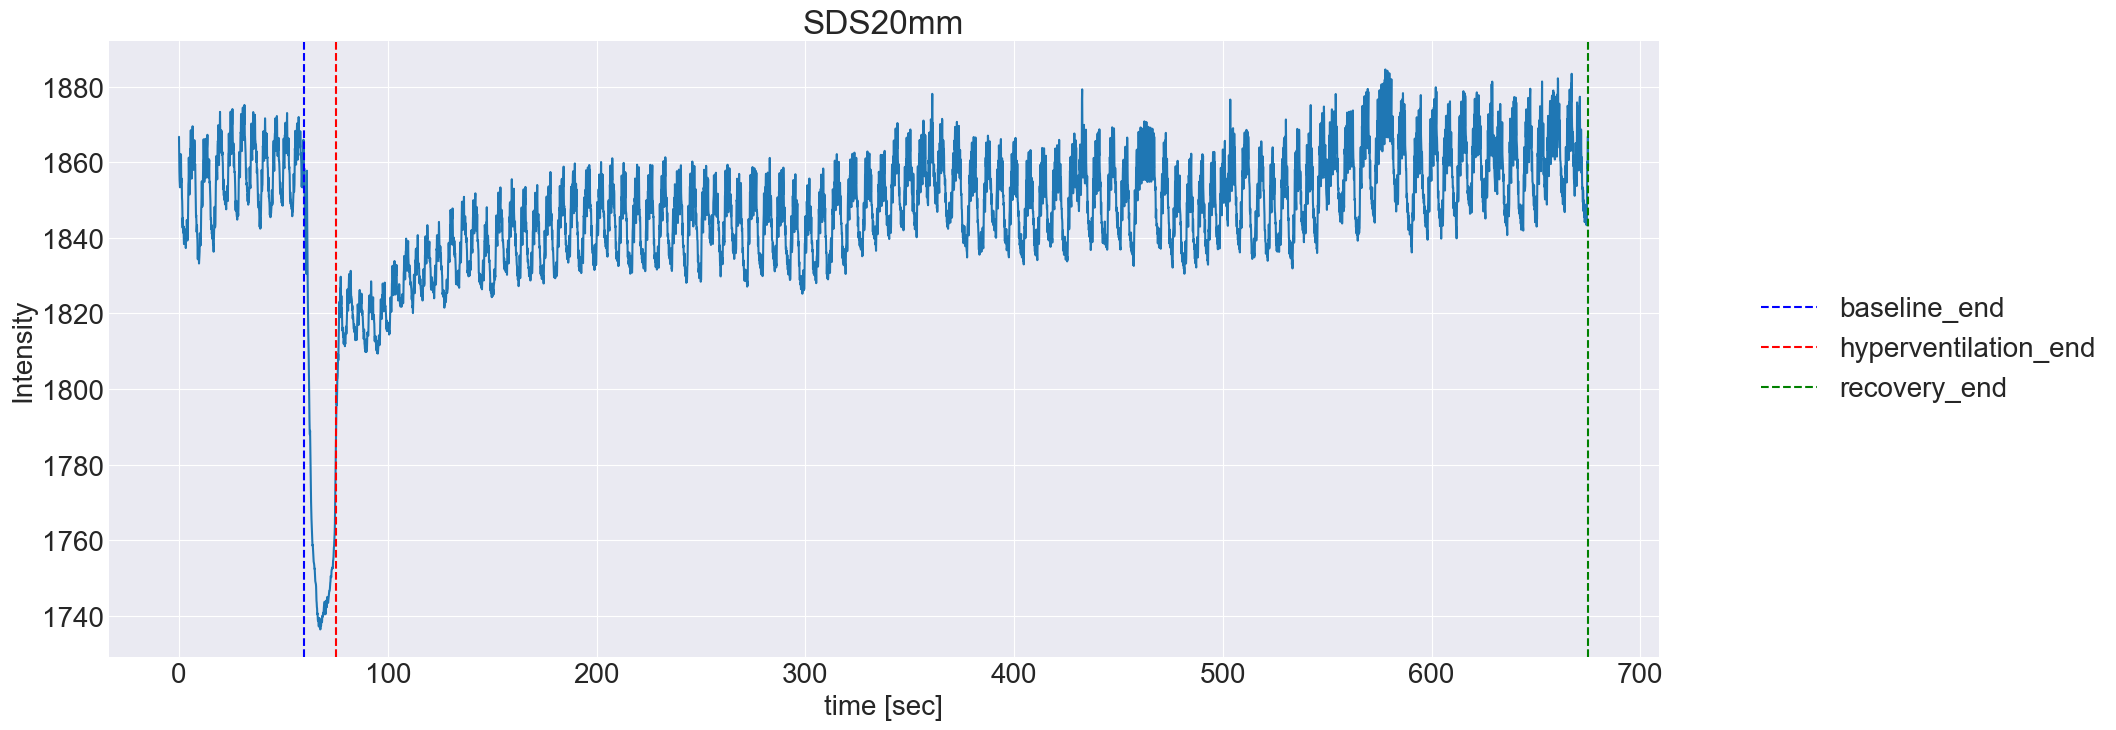

In [28]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(20,8))
time = np.linspace(0,recovery_end, raw_data.shape[0])
plt.plot(time, raw_data.mean(1))
plt.axvline(x=baseline_end, linestyle='--', color='b', label='baseline_end')
plt.axvline(x=HP_end, linestyle='--', color='r', label='hyperventilation_end')
plt.axvline(recovery_end, linestyle='--', color='g', label='recovery_end')
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),
          fancybox=True, shadow=True)
# plt.plot(time[max_id1], used_wl_data.mean(1)[max_id1], 'r.')
# plt.plot(time[min_id1], used_wl_data.mean(1)[min_id1], 'b.')
plt.xlabel("time [sec]")
plt.ylabel("Intensity")
plt.title('SDS20mm')
plt.savefig(os.path.join('pic', mother_folder_name, 'time', 'raw', 'raw_all_time_SDS20.png'), dpi=300, format='png', bbox_inches='tight')
plt.show()

In [15]:
plt.rcParams.update({'font.size': 12})
Processer.long_plot_all_fig(data=raw_data, 
            wavelength=total_wl,
            name='raw')
Processer.long_plot_all_fig(data=data_sub_bg, 
            wavelength=total_wl,
            name='remove_spike_and_bg')
Processer.long_plot_all_fig(data=data_moving_avg, 
            wavelength=moving_avg_wl_data,
            name='moving_average')

# for ts in range(0,recovery_end,time_interval):
#     td = ts + time_interval
#     plot_LPF_compare(BF_data=data_moving_avg, 
#                      AF_data=LPF_data,
#                      start_time=ts,
#                     end_time=td,
#                     time_resolution=time_resolution,
#                     name='compare_LPF')
# plot_all_fig(data=LPF_data, 
#         wavelength=moving_avg_wl_data,
#         name='LPF')  

    
Processer.long_plot_all_fig(data=data_EMD, 
            wavelength=moving_avg_wl_data,
            name='EMD')

Processer.plot_Rmax_Rmin(data=data_EMD,
                         wavelength=moving_avg_wl_data,
                         max_idx_Set=max_idx,
                         min_idx_Set=min_idx,
                         name="get_peak",
                         start_time=0,
                         end_time=recovery_end)

for using_num_IMF in [1,2,3]:
    Processer.plot_time_EMD(data=data_moving_avg,
                    name='EMD',
                    start_time=0,
                    end_time=recovery_end,
                    using_num_IMF=using_num_IMF)

    Processer.plot_compare_time_EMD(data=data_moving_avg,
                        name='compare',
                        start_time=0,
                        end_time=recovery_end,
                        using_num_IMF=using_num_IMF)

    
    for ts in range(0,recovery_end,time_interval):
        td = ts + time_interval
        Processer.plot_time_EMD(data=data_moving_avg,
                    name='EMD',
                    start_time=ts,
                    end_time=td,
                    using_num_IMF=using_num_IMF)

        Processer.plot_compare_time_EMD(data=data_moving_avg,
                            name='compare',
                            start_time=ts,
                            end_time=td,
                            using_num_IMF=using_num_IMF)

d:\ijv_code_organized\Internal-Jugular-Vein-Project\test_prediction_model_in_vivo\utils.py:460: RuntimeWarning: Mean of empty slice.
  R_max_spec = data[max_idx_subset, :].mean(0)
d:\ijv_code_organized\venv\lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
d:\ijv_code_organized\Internal-Jugular-Vein-Project\test_prediction_model_in_vivo\utils.py:461: RuntimeWarning: Mean of empty slice.
  R_min_spec = data[min_idx_subset, :].mean(0)


## Phantom Calibration

### Load measured phantom data

In [4]:

# get background Nx : time, Ny : intensity
background = pd.read_csv(os.path.join("dataset", subject, 'SDS2', date, "background.csv"))
used_wl = []
for k in background.keys().to_list()[1:]:
    used_wl += [float(k)]
background = background.to_numpy()[:,1:]
background = np.array(background, dtype=np.float64)

os.makedirs(os.path.join("pic", mother_folder_name, 'phantom', 'background'), exist_ok=True)
remove_spike_background = process_phantom.remove_spike(used_wl, background, 
                                                       normalStdTimes=6,
                                                       savepath=os.path.join("pic", mother_folder_name, 'phantom', 'background')) # remove spike
time_mean_background = remove_spike_background.mean(axis=0) # mean of background signal

# get measured phantom data
phantom_data = {} # CHIK3456
for ID in phantom_measured_ID:
    # define plot savepath
    os.makedirs(os.path.join("pic", mother_folder_name, 'phantom', ID), exist_ok=True)
    
    # import measured data
    data = pd.read_csv(os.path.join('dataset', subject, 'SDS2', date, f'{ID}.csv'))
    data = data.to_numpy()[:,1:]
    data = np.array(data, dtype=np.float64)
    
    # remove spike
    remove_spike_data = process_phantom.remove_spike(used_wl, data, 
                                                     normalStdTimes=6, 
                                                     savepath=os.path.join("pic", mother_folder_name,'phantom', ID)) # remove spike
    time_mean_data = remove_spike_data.mean(0) # mean of measured signal
    
    # subtract background
    time_mean_data_sub_background = time_mean_data - time_mean_background
    
    # Do moving avg of spectrum
    moving_avg_I_data, moving_avg_wl_data = process_phantom.moving_avg(used_wl_bandwidth = 3,
                                                       used_wl = used_wl,
                                                       time_mean_arr = time_mean_data_sub_background)
    
    phantom_data[ID] = moving_avg_I_data

target = []
target = []
target = []
target = [491]
target = [214]


### Load previous measured phantom data

In [17]:
if previous_date != date:
    # get background Nx : time, Ny : intensity
    background = pd.read_csv(os.path.join("dataset", subject, 'SDS2', previous_date, "background.csv"))
    used_wl = []
    for k in background.keys().to_list()[1:]:
        used_wl += [float(k)]
    background = background.to_numpy()[:,1:]
    background = np.array(background, dtype=np.float64)

    os.makedirs(os.path.join("pic", mother_folder_name, 'phantom', 'background'), exist_ok=True)
    remove_spike_background = process_phantom.remove_spike(used_wl, background, 
                                                        normalStdTimes=6,
                                                        savepath=os.path.join("pic", mother_folder_name, 'phantom', 'background')) # remove spike
    time_mean_background = remove_spike_background.mean(axis=0) # mean of background signal

    # get measured phantom data
    previous_phantom_data = {} # CHIK3456
    for ID in previous_phantom_measured_ID:
        # define plot savepath
        os.makedirs(os.path.join("pic", mother_folder_name, 'phantom', ID), exist_ok=True)
        
        # import measured data
        data = pd.read_csv(os.path.join('dataset', subject, 'SDS2', previous_date, f'{ID}.csv'))
        data = data.to_numpy()[:,1:]
        data = np.array(data, dtype=np.float64)
        
        # remove spike
        remove_spike_data = process_phantom.remove_spike(used_wl, data, 
                                                        normalStdTimes=6, 
                                                        savepath=os.path.join("pic", mother_folder_name,'phantom', ID)) # remove spike
        time_mean_data = remove_spike_data.mean(0) # mean of measured signal
        
        # subtract background
        time_mean_data_sub_background = time_mean_data - time_mean_background
        
        # Do moving avg of spectrum
        moving_avg_I_data, moving_avg_wl_data = process_phantom.moving_avg(used_wl_bandwidth = 3,
                                                        used_wl = used_wl,
                                                        time_mean_arr = time_mean_data_sub_background)
        
        previous_phantom_data[ID] = moving_avg_I_data
    
    for ID in phantom_measured_ID:    
        corr_raito = phantom_data[ID]/previous_phantom_data[ID]
        print(f'corr_ratio = {corr_raito}')
    corr_previous_phantom_data = previous_phantom_data.copy()
    for ID in previous_phantom_measured_ID:
        corr_previous_phantom_data[ID] = corr_raito*corr_previous_phantom_data[ID]
        
    phantom_data = corr_previous_phantom_data

FileNotFoundError: [Errno 2] No such file or directory: 'dataset\\KB\\SDS2\\20230819\\background.csv'

### Load simulated phantom data

In [5]:
# load used wavelength
with open(os.path.join("OPs_used", "wavelength.json"), "r") as f:
    wavelength = json.load(f)
    wavelength = wavelength['wavelength']

# binning meaurement wavelength 
binning_wavlength = 2 # nm
find_wl_idx = {}
for used_wl in wavelength:
    row = []
    for idx, test_wl in enumerate(moving_avg_wl_data):
        if abs(test_wl-used_wl) < binning_wavlength:
            row += [idx]          
    find_wl_idx[used_wl] = row
find_wl_idx

{700: [95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105],
 710: [122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132],
 717: [141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151],
 725: [163, 164, 165, 166, 167, 168, 169, 170, 171, 172],
 732: [181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191],
 740: [203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213],
 743: [211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221],
 748: [225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235],
 751: [233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243],
 753: [238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248],
 758: [252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262],
 763: [266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276],
 768: [279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289],
 780: [312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322],
 792: [346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356],
 798: [362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372],
 8

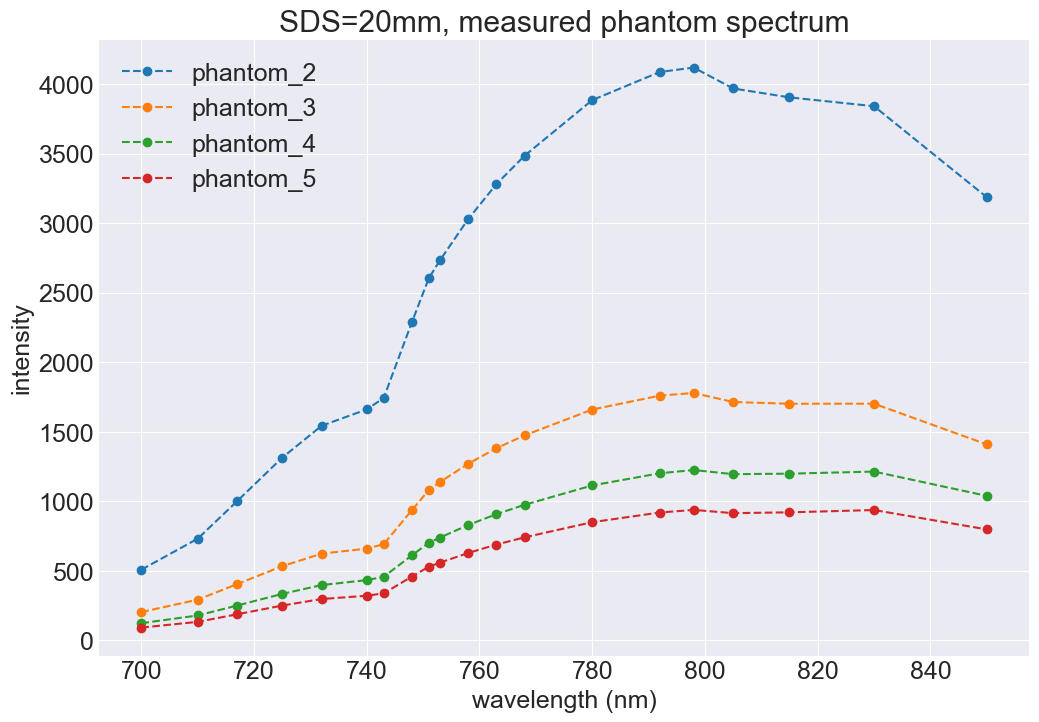

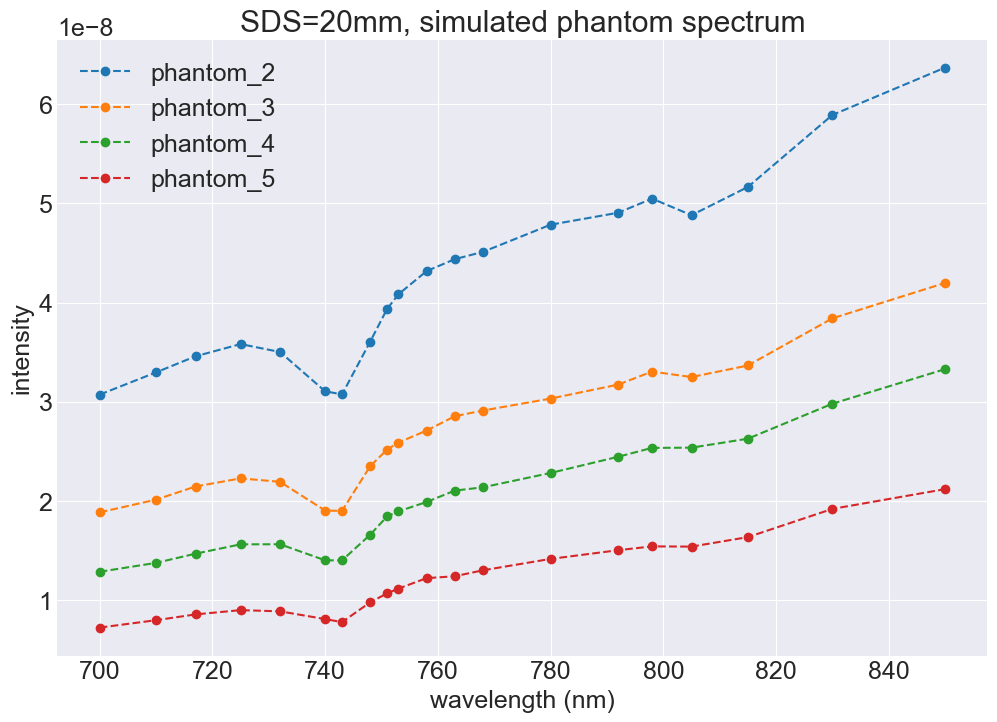

In [14]:
matplotlib.rcParams.update({'font.size': 18})
## Get the same simulated wavelength point from measured phantom
measured_phantom_data = []
plt.figure(figsize=(12,8))
for idx, out_k in enumerate(phantom_data.keys()):
    data = phantom_data[out_k]
    avg_wl_as_data = []
    for k in find_wl_idx.keys():
        average_idx = find_wl_idx[k]
        avg_wl_as_data += [data[average_idx].mean()]
    measured_phantom_data.append(avg_wl_as_data)
    plt.plot(wavelength, avg_wl_as_data, 'o--', label=f'phantom_{previous_phantom_measured_ID[idx]}')
plt.title("SDS=20mm, measured phantom spectrum")
plt.xlabel('wavelength (nm)')
plt.ylabel('intensity')
plt.legend()
plt.savefig(os.path.join("pic", mother_folder_name, 'phantom', "measured_phantom_adjust_wl.png"), dpi=300, format='png', bbox_inches='tight')
plt.show()
measured_phantom_data = np.array(measured_phantom_data)

## Get simulated phantom data
sim_phantom_data = []
plt.figure(figsize=(12,8))
for c in previous_phantom_measured_ID:
    data = np.load(os.path.join("dataset", "phantom_simulated", f'{c}.npy'))
    sim_phantom_data.append(data[:,SDS_idx].tolist())
    plt.plot(wavelength, data[:,SDS_idx], 'o--',label=f'phantom_{c}')
plt.title("SDS=20mm, simulated phantom spectrum")
plt.xlabel('wavelength (nm)')
plt.ylabel('intensity')
plt.legend()
plt.savefig(os.path.join("pic", mother_folder_name, 'phantom', "simulated_phantom_adjust_wl.png"), dpi=300, format='png', bbox_inches='tight')
plt.show()
sim_phantom_data = np.array(sim_phantom_data)


### Fit measured phantom and simulated phantom

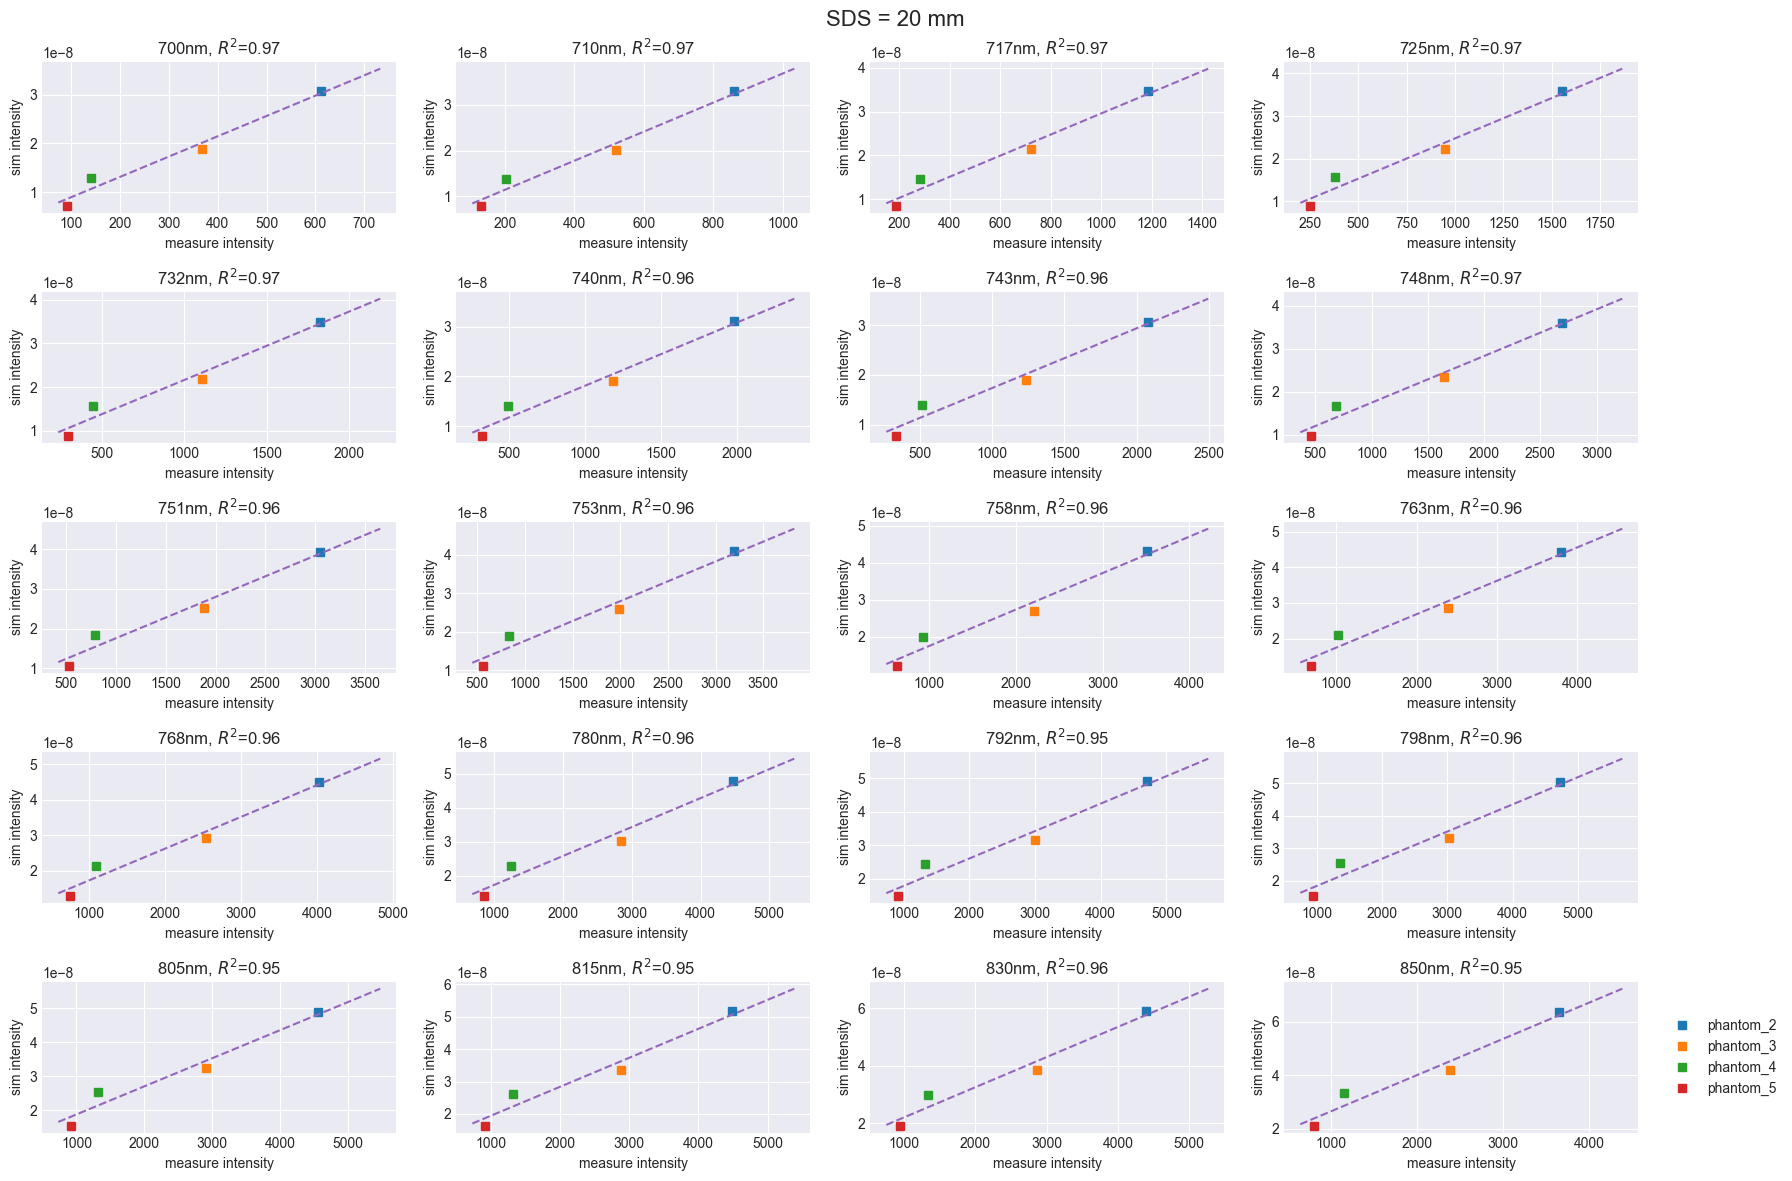

In [ ]:
fig = plt.figure(figsize=(18,12))
fig.suptitle(f"SDS = {using_SDS} mm", fontsize=16)
count = 1
for idx, used_wl in enumerate(wavelength):
    ## fit measured phantom and simulated phantom
    z = np.polyfit(measured_phantom_data[:, idx], sim_phantom_data[:,idx], 1)
    plotx = np.linspace(measured_phantom_data[-1, idx]*0.8,  measured_phantom_data[0, idx]*1.2,100)
    ploty = plotx*z[0] + z[1]
    calibrate_data = measured_phantom_data[:, idx]*z[0] + z[1]
    R_square = process_phantom.cal_R_square(calibrate_data, sim_phantom_data[:,idx]) # cal R square
    
    ## plot result
    ax = plt.subplot(5,4, count)
    ax.set_title(f"@wavelength={used_wl} nm")
    ax.set_title(f'{used_wl}nm, $R^{2}$={R_square:.2f}')
    for ID_idx, ID in enumerate(previous_phantom_measured_ID):
        ax.plot(measured_phantom_data[ID_idx, idx], sim_phantom_data[ID_idx,idx], 's', label=f'phantom_{ID}')
    ax.plot(plotx, ploty, '--')
    ax.set_xlabel("measure intensity")
    ax.set_ylabel("sim intensity")
    count += 1
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),
                    fancybox=True, shadow=True)
plt.tight_layout()
plt.savefig(os.path.join('pic', mother_folder_name, 'phantom', "all.png"), dpi=300, format='png', bbox_inches='tight')
plt.show()

### Save fitting result as csv

In [ ]:
result = {}
for idx, used_wl in enumerate(wavelength):
    z = np.polyfit(measured_phantom_data[:, idx], sim_phantom_data[:,idx], 1)
    result[used_wl] = z
result = pd.DataFrame(result)
os.makedirs(os.path.join("dataset",  subject, 'calibration_result', date) , exist_ok=True)
result.to_csv(os.path.join("dataset",  subject, 'calibration_result', date, "calibrate_SDS_2.csv"), index=False)

### Plot all measured phantom together

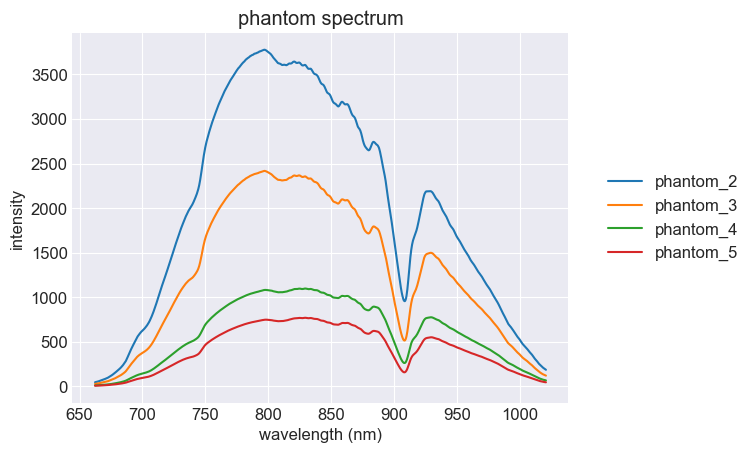

In [ ]:
for idx, k in enumerate(phantom_data.keys()):
    data = phantom_data[k]
    plt.plot(moving_avg_wl_data, data, label=f'phantom_{previous_phantom_measured_ID[idx]}')
plt.title('phantom spectrum')
plt.xlabel('wavelength (nm)')
plt.ylabel('intensity')
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),
                fancybox=True, shadow=True)
plt.savefig(os.path.join("pic", mother_folder_name, 'phantom', "measured_2345_phantom_result.png"), dpi=300, format='png', bbox_inches='tight')
plt.show()